In [1]:
"""Project Overview:

In this project, we will create an analysis of 10 countries along with
their capital cities. We aim to provide insights into various aspects of these cities,
including population size, tourist influx, and elevation. Furthermore,
we will gather weather data to determine the average temperatures, humidity levels, 
and atmospheric pressure. These parameters will be compared across all cities to identify trends and patterns.
Finally, we will develop predictive models to forecast weather conditions in these cities,
helping travelers decide on the best time to visit each location.
"""
# Project Objectives:

# 1. Population Analysis: Investigate the population sizes of the capital cities in the selected countries.
# 2. Tourism Data: Gather information on the number of tourists visiting each city to understand its popularity 
#    as a tourist destination.
# 3. Elevation Examination: Explore the elevations of the capital cities to determine their geographical characteristics.
# 4. Weather Data Collection: Collect weather data, including average temperatures,
#    humidity levels, and atmospheric pressure, for each city.
# 5. Comparative Analysis: Compare weather metrics across all cities to identify any notable variations or trends.
# 6. Predictive Modeling: Develop predictive models to forecast weather conditions in the selected cities,
#    aiding travelers in planning their trips effectively.


"""By addressing these objectives, we aim to provide valuable insights into the selected cities
and facilitate informed decision-making for travelers seeking to explore these destinations.
"""

'By addressing these objectives, we aim to provide valuable insights into the selected cities\nand facilitate informed decision-making for travelers seeking to explore these destinations.\n'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import time
import datetime
import json
import requests

In [2]:
unix_dates = []

current_time = round(time.time())  
for x in reversed(range(6)):  #we are put in the reverse range 6 to get data from the last 6 days, starting from the oldest date
    unix_dates.append(current_time - x * 24 * 60 *60)
    
# Let's create a city data dictionary
# key: City name
# value: Lista [population, elevation, longitude, latitude, annual_tourists]
cities = {
    'Zagreb': [792875, 122, 15.9775,45.8131, 2000000],
    'Amsterdam': [872680, -2, 4.9041, 52.3676, 20000000],
    'Berlin': [3769495, 34, 13.4050, 52.5200, 4000000],
    'Paris': [2148327, 35, 2.3522, 48.8566, 40000000],
    'Madrid': [3223334, 667, -3.7038, 40.4168, 3000000],
    'Rome': [2870500, 21, 12.4964, 41.9028, 10000000],
    'London': [8982256, 15, -0.1276, 51.5074, 20000000],
    'Vienna': [1897491, 151, 16.3738, 48.2082, 8000000],
    'Athens': [664046, 170, 23.7275, 37.9838, 5000000],
    'Stockholm': [965232, 44, 18.0686, 59.3293, 2000000]
}

# Api key that I received after registering on the site
api_key = 'a38edf57331518ae5f14c42cff1ba255'

In [3]:
Zagreb = requests.get(f'http://api.openweathermap.org/data/2.5/onecall/timemachine?lat={cities["Zagreb"][2]}&lon={cities["Zagreb"][3]}&dt={unix_dates[0]}&appid={api_key}').json()
Zagreb

{'lat': 15.9775,
 'lon': 45.8131,
 'timezone': 'Asia/Aden',
 'timezone_offset': 10800,
 'current': {'dt': 1706871110,
  'sunrise': 1706844407,
  'sunset': 1706885630,
  'temp': 302.61,
  'feels_like': 301.06,
  'pressure': 1011,
  'humidity': 23,
  'dew_point': 279.33,
  'uvi': 6.29,
  'clouds': 4,
  'visibility': 10000,
  'wind_speed': 5.06,
  'wind_deg': 20,
  'wind_gust': 4.14,
  'weather': [{'id': 800,
    'main': 'Clear',
    'description': 'clear sky',
    'icon': '01d'}]},
 'hourly': [{'dt': 1706832000,
   'temp': 293.34,
   'feels_like': 292.56,
   'pressure': 1013,
   'humidity': 44,
   'dew_point': 280.71,
   'uvi': 0,
   'clouds': 49,
   'visibility': 10000,
   'wind_speed': 1.64,
   'wind_deg': 330,
   'wind_gust': 2.11,
   'weather': [{'id': 802,
     'main': 'Clouds',
     'description': 'scattered clouds',
     'icon': '03n'}]},
  {'dt': 1706835600,
   'temp': 293.12,
   'feels_like': 292.32,
   'pressure': 1013,
   'humidity': 44,
   'dew_point': 280.51,
   'uvi': 0,
  

In [4]:
list(Zagreb.keys())

['lat', 'lon', 'timezone', 'timezone_offset', 'current', 'hourly']

In [5]:
Zagreb['hourly'][0]

{'dt': 1706832000,
 'temp': 293.34,
 'feels_like': 292.56,
 'pressure': 1013,
 'humidity': 44,
 'dew_point': 280.71,
 'uvi': 0,
 'clouds': 49,
 'visibility': 10000,
 'wind_speed': 1.64,
 'wind_deg': 330,
 'wind_gust': 2.11,
 'weather': [{'id': 802,
   'main': 'Clouds',
   'description': 'scattered clouds',
   'icon': '03n'}]}

In [3]:
def filter_city_weather_data_per_hour(hourly_data):
    temp = hourly_data['temp'] - 273.15
    humidity = hourly_data['humidity']
    pressure = hourly_data['pressure']
    clouds = hourly_data['clouds']
    dt = hourly_data['dt']
    wind_speed = hourly_data['wind_speed']
    wind_deg = hourly_data['wind_deg']
    
    return [
        round(temp, 2),
        humidity,
        pressure,
        clouds,
        dt,
        wind_speed,
        wind_deg,
        # we also add the time in a human-readable format
        datetime.datetime.strftime(datetime.datetime.fromtimestamp(dt), '%Y-%m-%d %H:%M:%S')]

In [4]:
# we go through all the cities
for city, values in cities.items():
    data_frame_list = []
    
    # we go through all the days
    for day in unix_dates:
        city_result = requests.get(f'http://api.openweathermap.org/data/2.5/onecall/timemachine?lat={values[3]}&lon={values[2]}&dt={day}&appid={api_key}').json()
        
        # we go through all hours of the day
        for hourly_data in city_result['hourly']:
            temp_df = filter_city_weather_data_per_hour(hourly_data)
            
            temp_df.append(city)
            temp_df.extend([values[0], values[1], values[4]])  # Extend temp_df with values
            data_frame_list.append(temp_df)
            
    headings = ['temp', 'humidity', 'pressure', 'clouds', 'dt', 'wind_speed', 'wind_deg', 'day', 'city', 'population', 'elevation', 'annual_tourists']
    data_frame = pd.DataFrame(data_frame_list, columns=headings)

    data_frame.to_csv(f'data/df_{city.lower()}.csv', mode='w', index=False)


In [7]:
df_zagreb = pd.read_csv('data/df_zagreb.csv')
df_amsterdam = pd.read_csv('data/df_amsterdam.csv')
df_berlin = pd.read_csv('data/df_berlin.csv')
df_paris = pd.read_csv('data/df_paris.csv')
df_madrid = pd.read_csv('data/df_madrid.csv')
df_rome = pd.read_csv('data/df_rome.csv')
df_london = pd.read_csv('data/df_london.csv')
df_vienna = pd.read_csv('data/df_vienna.csv')
df_athens = pd.read_csv('data/df_athens.csv')
df_stockholm = pd.read_csv('data/df_stockholm.csv')


df_zagreb

,temp,humidity,pressure,clouds,dt,wind_speed,wind_deg,day,city,population,elevation,annual_tourists
0,4.54,80,1029,48,1706832000,0.24,123,2024-02-02 01:00:00,Zagreb,792875,122,2000000
1,4.40,82,1030,69,1706835600,0.24,42,2024-02-02 02:00:00,Zagreb,792875,122,2000000
2,4.95,80,1030,85,1706839200,0.16,310,2024-02-02 03:00:00,Zagreb,792875,122,2000000
3,4.96,82,1030,90,1706842800,0.34,88,2024-02-02 04:00:00,Zagreb,792875,122,2000000
4,4.89,84,1030,92,1706846400,0.97,87,2024-02-02 05:00:00,Zagreb,792875,122,2000000
...,...,...,...,...,...,...,...,...,...,...,...,...
126,9.38,74,1012,40,1707285600,2.57,280,2024-02-07 07:00:00,Zagreb,792875,122,2000000
127,10.50,74,1012,0,1707289200,2.57,260,2024-02-07 08:00:00,Zagreb,792875,122,2000000
128,12.16,69,1012,20,1707292800,2.57,250,2024-02-07 09:00:00,Zagreb,792875,122,2000000
129,13.27,65,1012,20,1707296400,3.60,260,2024-02-07 10:00:00,Zagreb,792875,122,2000000


In [9]:
df_zagreb.dtypes

temp               float64
humidity             int64
pressure             int64
clouds               int64
dt                   int64
wind_speed         float64
wind_deg             int64
day                 object
city                object
population           int64
elevation            int64
annual_tourists      int64
dtype: object

In [10]:
df_zagreb.isnull().sum()

temp               0
humidity           0
pressure           0
clouds             0
dt                 0
wind_speed         0
wind_deg           0
day                0
city               0
population         0
elevation          0
annual_tourists    0
dtype: int64

C:\Users\zoccc\AppData\Local\Temp\ipykernel_9124\3367855587.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


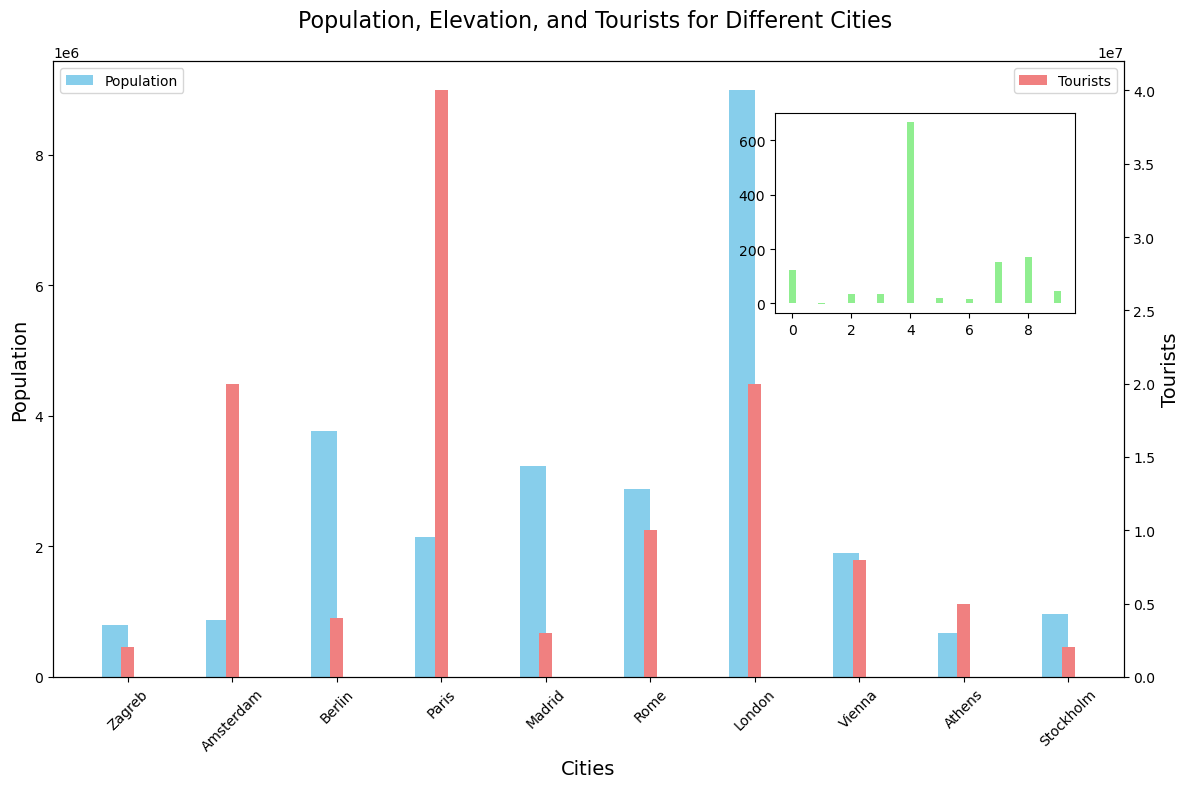

In [5]:
# Data on population, elevation, and number of tourists for different cities
populations = [792875, 872680, 3769495, 2148327, 3223334, 2870500, 8982256, 1897491, 664046, 965232]
elevations = [122, -2, 34, 35, 667, 21, 15, 151, 170, 44]
tourists = [2000000, 20000000, 4000000, 40000000, 3000000, 10000000, 20000000, 8000000, 5000000, 2000000]
cities = ['Zagreb', 'Amsterdam', 'Berlin', 'Paris', 'Madrid', 'Rome', 'London', 'Vienna', 'Athens', 'Stockholm']

# Setting the width of the bars
bar_width = 0.25

# Creating an array representing the positions of the bars on the x-axis
index = np.arange(len(cities))

# Creating the plot
fig, ax1 = plt.subplots(figsize=(12, 8))

# Adding bars for population
ax1.bar(index, populations, bar_width, label='Population', color='skyblue')

# Adding bars for number of tourists (using the secondary y-axis)
ax2 = ax1.twinx()
ax2.bar(index + bar_width/2, tourists, bar_width/2, label='Tourists', color='lightcoral')

# Adding bars for elevation (in the top right corner)
ax3 = fig.add_axes([0.65, 0.6, 0.25, 0.25])
ax3.bar(index, elevations, bar_width, label='Elevation', color='lightgreen')

# Setting labels on the x-axis for the main plot
ax1.set_xlabel('Cities', fontsize=14)

# Setting labels on the y-axis for the main plot
ax1.set_ylabel('Population', fontsize=14)

# Setting labels on the y-axis for the secondary plot
ax2.set_ylabel('Tourists', fontsize=14)

# Setting labels on the x-axis for the secondary plot
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(cities, rotation=45)

# Setting the title of the plot
plt.suptitle('Population, Elevation, and Tourists for Different Cities', fontsize=16)

# Adding a legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Displaying the plot
plt.tight_layout()
plt.show()

In [12]:
"""From this graph, we can see that London has the largest population,
while Athens and Zagreb have the smallest. Additionally, Paris is the most visited tourist destination,
followed by Amsterdam and London. Madrid has the highest elevation among the cities."""

'From this graph, we can see that London has the largest population,\nwhile Athens and Zagreb have the smallest. Additionally, Paris is the most visited tourist destination,\nfollowed by Amsterdam and London. Madrid has the highest elevation among the cities.'

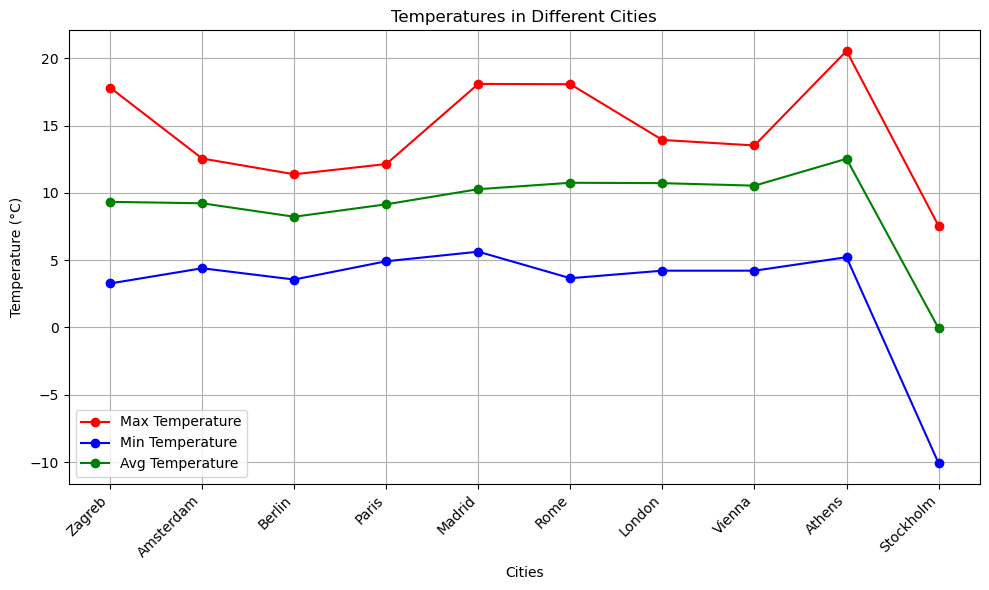

In [8]:
import matplotlib.pyplot as plt

# City Names
cities = ['Zagreb', 'Amsterdam', 'Berlin', 'Paris', 'Madrid', 'Rome', 'London', 'Vienna', 'Athens', 'Stockholm']

# Data on maximum, minimum, and average temperatures for each city
temp_max = [df_zagreb['temp'].max(),
            df_amsterdam['temp'].max(),
            df_berlin['temp'].max(),
            df_paris['temp'].max(),
            df_madrid['temp'].max(),
            df_rome['temp'].max(),
            df_london['temp'].max(),
            df_vienna['temp'].max(),
            df_athens['temp'].max(),
            df_stockholm['temp'].max()]

temp_min = [df_zagreb['temp'].min(),
            df_amsterdam['temp'].min(),
            df_berlin['temp'].min(),
            df_paris['temp'].min(),
            df_madrid['temp'].min(),
            df_rome['temp'].min(),
            df_london['temp'].min(),
            df_vienna['temp'].min(),
            df_athens['temp'].min(),
            df_stockholm['temp'].min()]

temp_avg = [df_zagreb['temp'].mean(),
            df_amsterdam['temp'].mean(),
            df_berlin['temp'].mean(),
            df_paris['temp'].mean(),
            df_madrid['temp'].mean(),
            df_rome['temp'].mean(),
            df_london['temp'].mean(),
            df_vienna['temp'].mean(),
            df_athens['temp'].mean(),
            df_stockholm['temp'].mean()]

humidity_avg = [df_zagreb['humidity'].mean(),
                df_amsterdam['humidity'].mean(),
                df_berlin['humidity'].mean(),
                df_paris['humidity'].mean(),
                df_madrid['humidity'].mean(),
                df_rome['humidity'].mean(),
                df_london['humidity'].mean(),
                df_vienna['humidity'].mean(),
                df_athens['humidity'].mean(),
                df_stockholm['humidity'].mean()]

pressure_avg = [df_zagreb['pressure'].mean(),
                df_amsterdam['pressure'].mean(),
                df_berlin['pressure'].mean(),
                df_paris['pressure'].mean(),
                df_madrid['pressure'].mean(),
                df_rome['pressure'].mean(),
                df_london['pressure'].mean(),
                df_vienna['pressure'].mean(),
                df_athens['pressure'].mean(),
                df_stockholm['pressure'].mean()]

clouds_avg = [df_zagreb['clouds'].mean(),
              df_amsterdam['clouds'].mean(),
              df_berlin['clouds'].mean(),
              df_paris['clouds'].mean(),
              df_madrid['clouds'].mean(),
              df_rome['clouds'].mean(),
              df_london['clouds'].mean(),
              df_vienna['clouds'].mean(),
              df_athens['clouds'].mean(),
              df_stockholm['clouds'].mean()]



# Creating a graph
plt.figure(figsize=(10, 6))

# Graph for maximum temperatures
plt.plot(cities, temp_max, marker='o', label='Max Temperature', color='red')

# Graph for minimum temperatures
plt.plot(cities, temp_min, marker='o', label='Min Temperature', color='blue')

plt.plot(cities, temp_avg, marker='o', label='Avg Temperature', color='green')

# Adding tags to the margins and title
plt.xlabel('Cities')
plt.ylabel('Temperature (°C)')
plt.title('Temperatures in Different Cities')
plt.xticks(rotation=45, ha='right')  # Rotacija oznaka gradova radi bolje čitljivosti
plt.grid(True)  # Dodavanje mreže

# Adding a legend
plt.legend()

# Show graf
plt.tight_layout()
plt.show()

In [14]:
'''From the graph, we can observe that Stockholm is the coldest city with the lowest minimum temperature.
Therefore, if we prefer a city with fewer people and colder weather to enjoy winter activities such as skiing,
we would recommend that city. On the other hand, Athens has the highest daily temperature, making it a suitable choice
for those who prefer sunnier days during the winter.'''

'From the graph, we can observe that Stockholm is the coldest city with the lowest minimum temperature.\nTherefore, if we prefer a city with fewer people and colder weather to enjoy winter activities such as skiing,\nwe would recommend that city. On the other hand, Athens has the highest daily temperature, making it a suitable choice\nfor those who prefer sunnier days during the winter.'

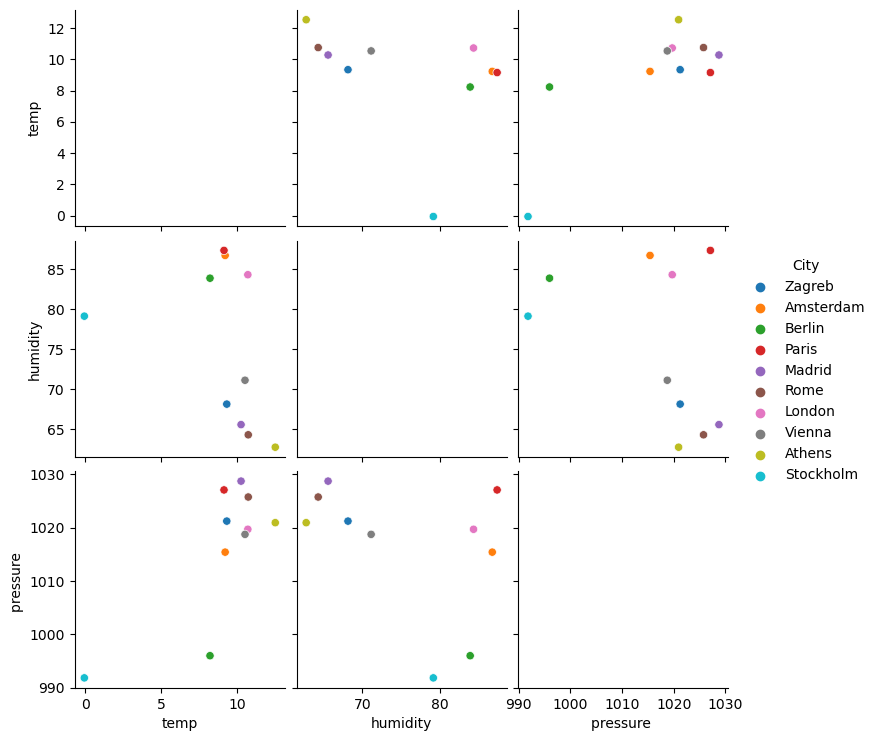

In [9]:
# Create a DataFrame
data = pd.DataFrame({'temp': temp_avg, 'humidity': humidity_avg, 'pressure ': pressure_avg, 'City': cities})

# Create scatter plot matrix
sns.pairplot(data, hue='City', height=2.5)
plt.show()


In [16]:
#     From this graph, we can see the temperature, pressure, and humidity for each city.

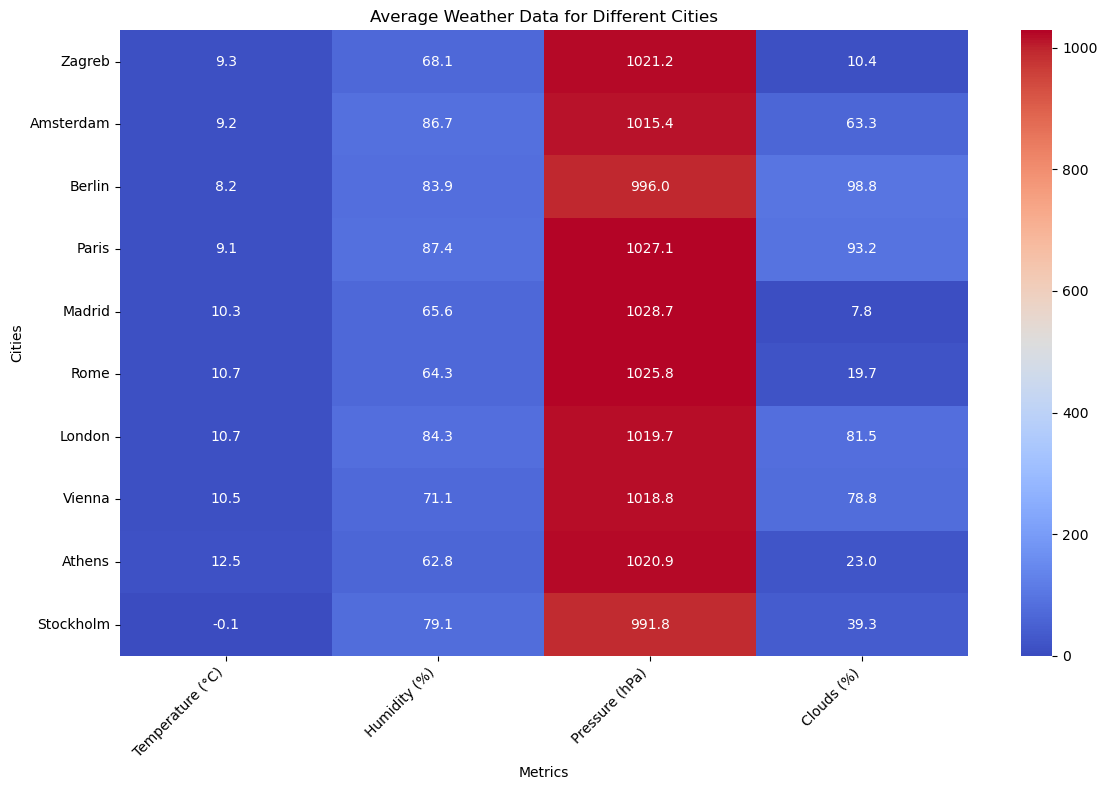

In [10]:
data = {
    'Cities': ['Zagreb', 'Amsterdam', 'Berlin', 'Paris', 'Madrid', 'Rome', 'London', 'Vienna', 'Athens', 'Stockholm'],
    'Temperature (°C)': temp_avg,
    'Humidity (%)': humidity_avg,
    'Pressure (hPa)': pressure_avg,
    'Clouds (%)': clouds_avg
}

# Pretvaranje podataka u DataFrame
df = pd.DataFrame(data)

# Postavljanje 'Cities' kao indeks
df.set_index('Cities', inplace=True)

# Stvaranje heatmap-a
plt.figure(figsize=(12, 8))
sns.heatmap(df, annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Average Weather Data for Different Cities')
plt.xlabel('Metrics')
plt.ylabel('Cities')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [18]:
#       Here we can see the data for temperature, cloud cover, pressure, and humidity in numbers so that
#       we can better compare it to the previous graph.

In [11]:
def display_wind_rose(values, city_name):
    N = 8
    
    hist, _ = np.histogram(values, N, [0, 360])
    
    # x-axis (angle, degrees) in radians
    theta = np.arange(0, 2*np.pi, 2*np.pi/N)
    
    # Must be polar coordinates for the graph to be circular
    ax = plt.axes(polar=True)
    # Clockwise direction
    ax.set_theta_direction(-1)
    # Set 0° to North
    ax.set_theta_offset(np.pi / 2)
    
    max_value = max(hist)
    colors = [(1 - x/max_value, 1 - x/max_value, 0.75) for x in hist]
    
    plt.title(city_name, x=0.2, fontsize=20)
    
    tick_labels = ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]
    plt.bar(theta, hist, color=colors, align="edge", tick_label=tick_labels)


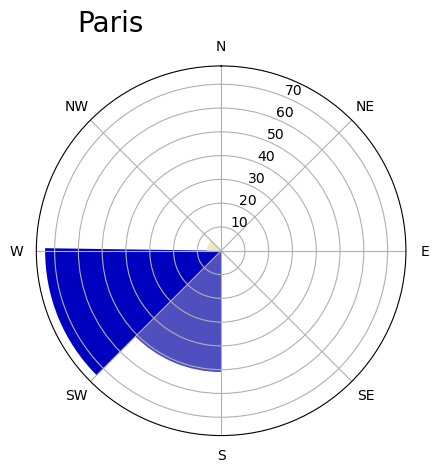

In [12]:
display_wind_rose(df_paris['wind_deg'], 'Paris')

In [21]:
"""This function displays a wind rose graph, which represents the distribution of
wind directions in degrees (0 to 360) for a given city. It divides the circle into
sectors representing different compass directions
(North, Northeast, East, Southeast, South, Southwest, West, Northwest) and plots bars
indicating the frequency or intensity of winds blowing from each direction."""

'This function displays a wind rose graph, which represents the distribution of\nwind directions in degrees (0 to 360) for a given city. It divides the circle into\nsectors representing different compass directions\n(North, Northeast, East, Southeast, South, Southwest, West, Northwest) and plots bars\nindicating the frequency or intensity of winds blowing from each direction.'

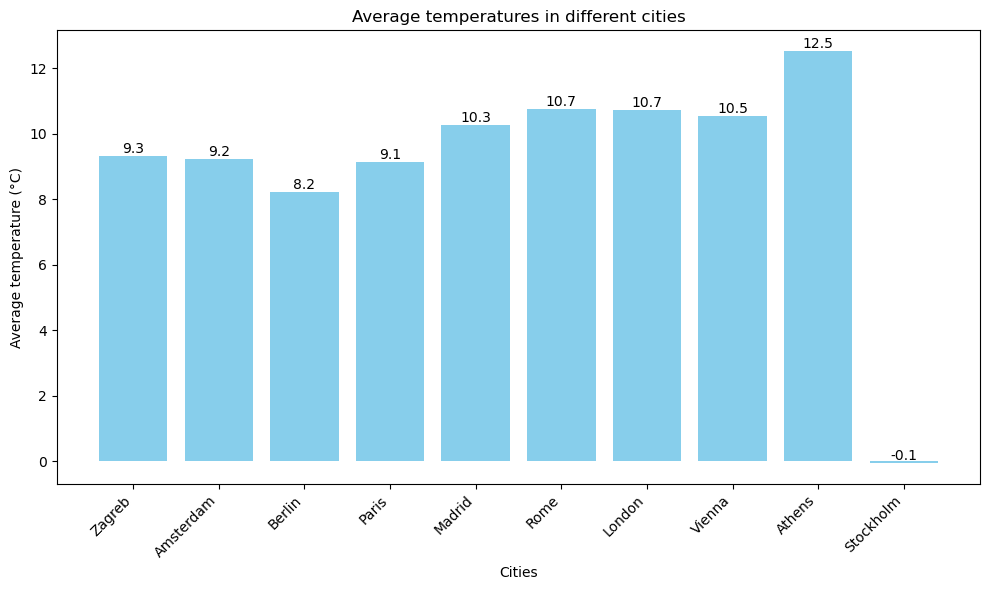

In [13]:
# Create a bar graph
plt.figure(figsize=(10, 6))

# Bar graph for average temperatures
plt.bar(cities, temp_avg, color='skyblue')

# Adding labels to axes and title
plt.xlabel('Cities')
plt.ylabel('Average temperature (°C)')
plt.title('Average temperatures in different cities')
plt.xticks(rotation=45, ha='right')  # Rotate city labels for better readability

# Adding values on top of each bar
for i, temp in enumerate(temp_avg):
    plt.text(i, temp, f'{temp:.1f}', ha='center', va='bottom')

# Show the graph
plt.tight_layout()
plt.show()

In [23]:
#    Here we are displaying a graph of average temperatures over the past 5 days, and then we will attempt
#    to predict what the temperature might be in the next few days.

C:\Users\zoccc\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\zoccc\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\zoccc\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\zoccc\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\zoccc\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\zoccc\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not ha

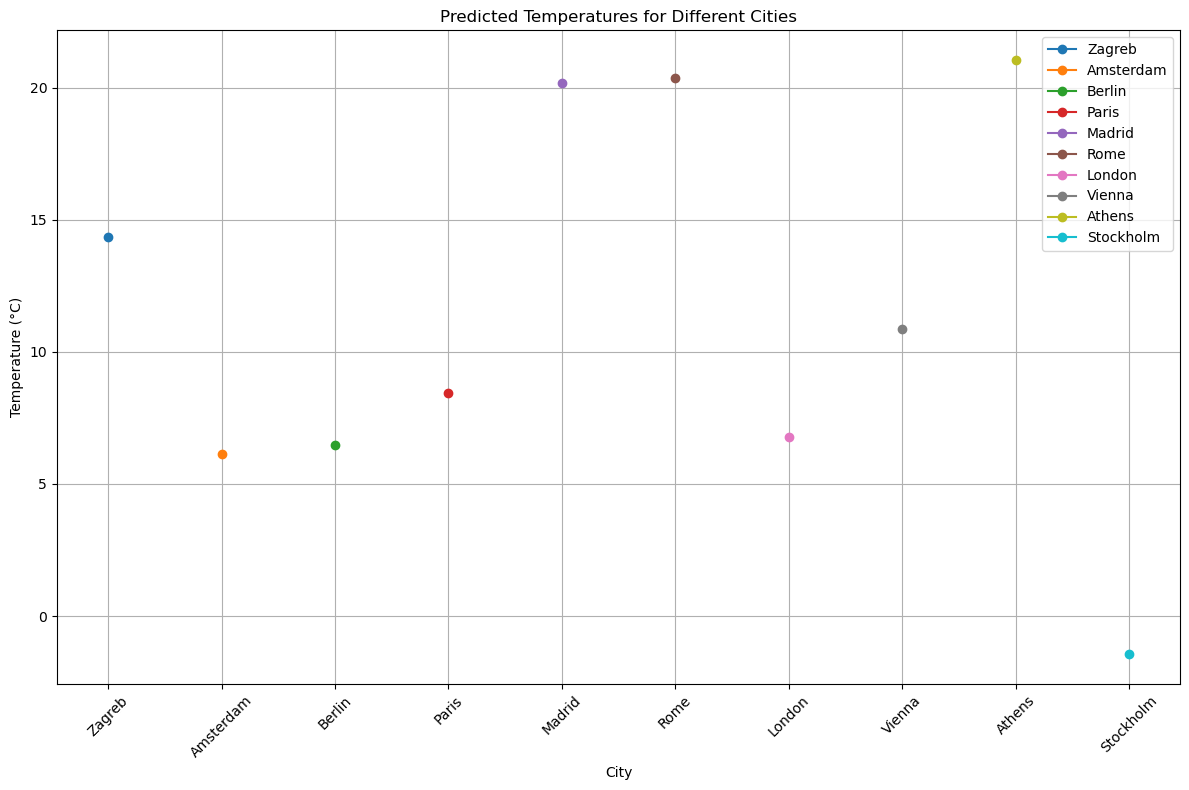

Future Temperature Predictions:
Zagreb: [14.36342645]
Amsterdam: [6.1259707]
Berlin: [6.46808803]
Paris: [8.44939382]
Madrid: [20.19026445]
Rome: [20.36700442]
London: [6.79264529]
Vienna: [10.85943251]
Athens: [21.04237586]
Stockholm: [-1.4389885]


In [14]:
def train_and_predict(city_name):
    # Loading the data for the specified city
    data = pd.read_csv(f'data/df_{city_name.lower()}.csv')

    # Data for the model
    X = data[['humidity', 'pressure', 'clouds', 'wind_speed']]
    y = data['temp']

    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initializing and training the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predicting temperatures for the test set
    predictions = model.predict(X_test)

    # Predicting future weather conditions
    future_weather = model.predict([[60, 1013, 20, 5]])  # example: 60% humidity, 1013 mbar pressure, 20% clouds, 5 m/s wind speed
    return model, future_weather

# List of cities
cities = ['Zagreb', 'Amsterdam', 'Berlin', 'Paris', 'Madrid', 'Rome', 'London', 'Vienna', 'Athens', 'Stockholm']

# Dictionary to store future weather predictions for each city
future_temperatures = {}

# Plotting the predicted temperatures for all cities
plt.figure(figsize=(12, 8))

for city in cities:
    model, future_temp = train_and_predict(city)
    future_temperatures[city] = future_temp
    plt.plot(city, future_temp, marker='o', label=city)

plt.title('Predicted Temperatures for Different Cities')
plt.xlabel('City')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the future temperature predictions for each city
print("Future Temperature Predictions:")
for city, temp in future_temperatures.items():
    print(f"{city}: {temp}")


In [25]:
"""The function train_and_predict(city_name) is responsible for training the model and making future
temperature predictions for a specified city. It loads the data for the given city, prepares the features
and target variables, splits the data, trains the linear regression model, predicts temperatures
for the test set, and finally predicts future temperatures based on a set of predefined weather conditions"""

'The function train_and_predict(city_name) is responsible for training the model and making future\ntemperature predictions for a specified city. It loads the data for the given city, prepares the features\nand target variables, splits the data, trains the linear regression model, predicts temperatures\nfor the test set, and finally predicts future temperatures based on a set of predefined weather conditions'

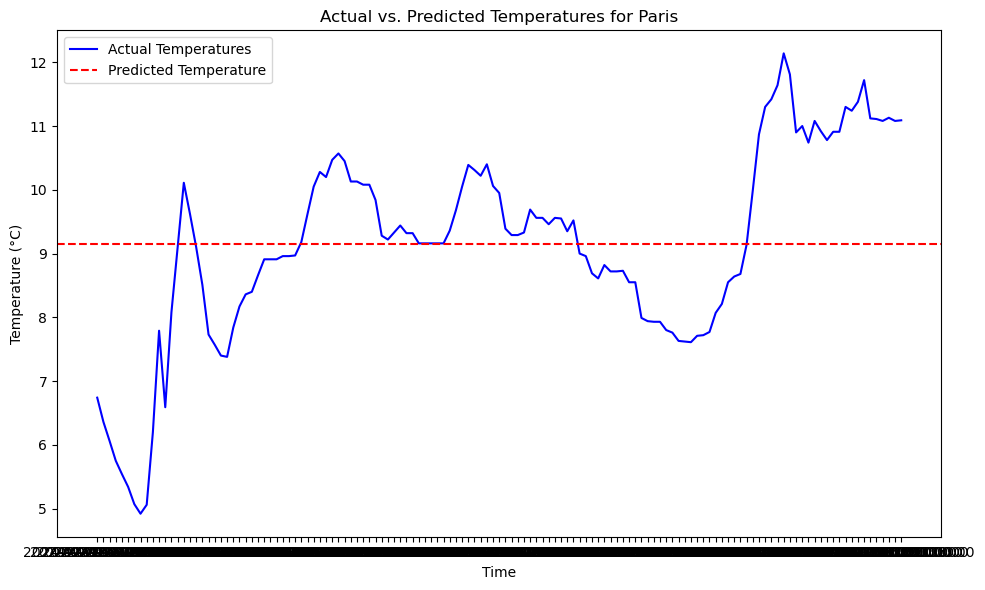

In [15]:
# Loading actual temperature data for Paris from the CSV file
df_paris = pd.read_csv('data/df_paris.csv')

# Filling actual_temperatures with actual temperature values from the DataFrame
actual_temperatures = df_paris['temp']

# Number of timestamps (e.g., days or hours)
num_timestamps = len(actual_temperatures)

# Timestamps (e.g., days or hours)
timestamps = df_paris['day']

# Predicted temperature assumption (set to the mean of actual temperatures here)
predicted_temp = actual_temperatures.mean()  # Setting predicted temperatures assumption to the mean of actual temperatures

# Creating the plot
plt.figure(figsize=(10, 6))

# Actual temperatures (line or points)
plt.plot(timestamps, actual_temperatures, label='Actual Temperatures', color='blue')

# Predicted temperature (line or point)
plt.axhline(y=predicted_temp, linestyle='--', label='Predicted Temperature', color='red')

plt.title('Actual vs. Predicted Temperatures for Paris')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()

# Displaying the plot
plt.tight_layout()
plt.show()


In [27]:
"""This code snippet calls the train_and_predict(city_name) function for Zagreb to obtain the predictions,
and then it proceeds to plot the graph as before. This way, the variable predictions
is properly defined before being used in the plt.axhline() function."""

'This code snippet calls the train_and_predict(city_name) function for Zagreb to obtain the predictions,\nand then it proceeds to plot the graph as before. This way, the variable predictions\nis properly defined before being used in the plt.axhline() function.'

In [ ]:
# Importing pandas library
import pandas as pd

# City data dictionary with average temperature, humidity, pressure, and clouds
city_data = {
    'Zagreb': {'temperature_avg': temp_avg[0], 'humidity_avg': humidity_avg[0], 'pressure_avg': pressure_avg[0], 'clouds_avg': clouds_avg[0], 'population': 792875, 'elevation': 122, 'tourism_level': 2000000},
    'Amsterdam': {'temperature_avg': temp_avg[1], 'humidity_avg': humidity_avg[1], 'pressure_avg': pressure_avg[1], 'clouds_avg': clouds_avg[1], 'population': 872680, 'elevation': -2, 'tourism_level': 20000000},
    'Berlin': {'temperature_avg': temp_avg[2], 'humidity_avg': humidity_avg[2], 'pressure_avg': pressure_avg[2], 'clouds_avg': clouds_avg[2], 'population': 3769495, 'elevation': 34, 'tourism_level': 4000000},
    'Paris': {'temperature_avg': temp_avg[3], 'humidity_avg': humidity_avg[3], 'pressure_avg': pressure_avg[3], 'clouds_avg': clouds_avg[3], 'population': 2148327, 'elevation': 35, 'tourism_level': 40000000},
    'Madrid': {'temperature_avg': temp_avg[4], 'humidity_avg': humidity_avg[4], 'pressure_avg': pressure_avg[4], 'clouds_avg': clouds_avg[4], 'population': 3223334, 'elevation': 667, 'tourism_level': 3000000},
    'Rome': {'temperature_avg': temp_avg[5], 'humidity_avg': humidity_avg[5], 'pressure_avg': pressure_avg[5], 'clouds_avg': clouds_avg[5], 'population': 2870500, 'elevation': 21, 'tourism_level': 10000000},
    'London': {'temperature_avg': temp_avg[6], 'humidity_avg': humidity_avg[6], 'pressure_avg': pressure_avg[6], 'clouds_avg': clouds_avg[6], 'population': 8982256, 'elevation': 15, 'tourism_level': 20000000},
    'Vienna': {'temperature_avg': temp_avg[7], 'humidity_avg': humidity_avg[7], 'pressure_avg': pressure_avg[7], 'clouds_avg': clouds_avg[7], 'population': 1897491, 'elevation': 151, 'tourism_level': 8000000},
    'Athens': {'temperature_avg': temp_avg[8], 'humidity_avg': humidity_avg[8], 'pressure_avg': pressure_avg[8], 'clouds_avg': clouds_avg[8], 'population': 664046, 'elevation': 170, 'tourism_level': 5000000},
    'Stockholm': {'temperature_avg': temp_avg[9], 'humidity_avg': humidity_avg[9], 'pressure_avg': pressure_avg[9], 'clouds_avg': clouds_avg[9], 'population': 965232, 'elevation': 44, 'tourism_level': 2000000}
}

def display_city_info(city_name):
    city_info = city_data[city_name]
    print(f"City: {city_name}")
    print(f"Population: {city_info['population']}")
    print(f"Elevation: {city_info['elevation']} meters")
    print(f"Tourism Level: {city_info['tourism_level']}")
    print(f"Average Temperature: {round(city_info['temperature_avg'], 2)}°C")
    print(f"Average Humidity: {round(city_info['humidity_avg'], 2)}%")
    print(f"Average Pressure: {round(city_info['pressure_avg'], 2)} mbar")
    print(f"Average Cloudiness: {round(city_info['clouds_avg'], 2)}%")

def main():
    print("Choose the city you want to see information about:")
    print("For exit write exit")
    for city in city_data.keys():
        print(city)
    
    selected_city = input("Enter the name of the city: ").capitalize()
    while True:
        if selected_city in city_data:
            print('************')
            model, future_temp = train_and_predict(selected_city)
            print(f"Predicted Temperature: {round(future_temp[0], 2)}°C")
            display_city_info(selected_city)
            selected_city = input("Enter the name of the city: ").capitalize()
        elif selected_city == 'exit':
            break
        else:
            print("Invalid city name. Please choose from the provided list.")

if __name__ == "__main__":
    main()




Choose the city you want to see information about:
For exit write exit
Zagreb
Amsterdam
Berlin
Paris
Madrid
Rome
London
Vienna
Athens
Stockholm
Enter the name of the city: zagreb


C:\Users\zoccc\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


************
Predicted Temperature: 14.36°C
City: Zagreb
Population: 792875
Elevation: 122 meters
Tourism Level: 2000000
Average Temperature: 9.33°C
Average Humidity: 68.15%
Average Pressure: 1021.24 mbar
Average Cloudiness: 10.37%
Enter the name of the city: paris


C:\Users\zoccc\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


************
Predicted Temperature: 8.42°C
City: Paris
Population: 2148327
Elevation: 35 meters
Tourism Level: 40000000
Average Temperature: 9.12°C
Average Humidity: 87.55%
Average Pressure: 1027.09 mbar
Average Cloudiness: 93.24%
Enter the name of the city: exit


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

